In [85]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../../../../nathan.mplstyle')

In [80]:
import cymetric as cym
from cymetric import filters 
from cymetric import graphs 
from cymetric import timeseries 
from cymetric import tools
import graphviz
import sqlite3

# Cymetric

In [113]:
conn.close()
cursor.close()

ProgrammingError: Cannot operate on a closed database.

In [114]:
db = cym.dbopen('single_xe100_out.sqlite')
evaler = cym.Evaluator(db, write=False)

In [115]:
time = evaler.eval('TimeList')
commission_df = evaler.eval('BuildSeries')
decommission_df = evaler.eval('DecommissionSeries')

commission_df = commission_df.rename(index=str, columns={'EnterTime': 'Time'})
commission_df = tools.add_missing_time_step(commission_df, time)
commission_by_prototype = pd.pivot_table(
        commission_df,
        values='Count',
        index='Time',
        columns='Prototype',
        fill_value=0)

In [116]:
commission_by_prototype

Prototype,0,DryStorage,Enrichment,FuelCycle,Mine,Sink_LLW,United States,WetStorage,Xe_100CoolingPool,Xe_100_1
Time,,,,,,,,,,
0,0.0,1.0,5.0,1.0,5.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
decommission_df

,SimId,ExitTime,Prototype,Count
0,474ee644-2066-4f79-b47e-9dc372357abe,731,Xe_100_1,1


In [104]:
decommission_df = decommission_df.rename(index=str, columns={'ExitTime': 'Time'})


In [105]:
decommission_df

,SimId,Time,Prototype,Count
0,474ee644-2066-4f79-b47e-9dc372357abe,731,Xe_100_1,1


In [106]:
decommission_df = tools.add_missing_time_step(decommission_df, time)


,Time,SimId,Prototype,Count
0,0,0,0,0.0
1,1,0,0,0.0
2,2,0,0,0.0
3,3,0,0,0.0
4,4,0,0,0.0
...,...,...,...,...
1495,1495,0,0,0.0
1496,1496,0,0,0.0
1497,1497,0,0,0.0
1498,1498,0,0,0.0


In [112]:
decommission_df['Prototype'][720:740]

720           0
721           0
722           0
723           0
724           0
725           0
726           0
727           0
728           0
729           0
730           0
731    Xe_100_1
732           0
733           0
734           0
735           0
736           0
737           0
738           0
739           0
Name: Prototype, dtype: object

In [109]:
decommission_by_prototype = pd.pivot_table(
        decommission_df,
        values='Count',
        index='Time',
        columns='Prototype',
        fill_value=0)

In [111]:
decommission_df

,Time,SimId,Prototype,Count
0,0,0,0,0.0
1,1,0,0,0.0
2,2,0,0,0.0
3,3,0,0,0.0
4,4,0,0,0.0
...,...,...,...,...
1495,1495,0,0,0.0
1496,1496,0,0,0.0
1497,1497,0,0,0.0
1498,1498,0,0,0.0


In [118]:
negative_count = -decommission_df['Count']
decommission_df = decommission_df.drop('Count', axis=1)
decommission_df = pd.concat([decommission_df, negative_count], axis=1)
decommission_df.rename(columns={'ExitTime': 'Time'}, inplace=True)
decommission_by_prototype = decommission_df.pivot(index='Time', columns='Prototype')['Count'].reset_index()

In [119]:
decommission_by_prototype

Prototype,Time,Xe_100_1
0,731,-1


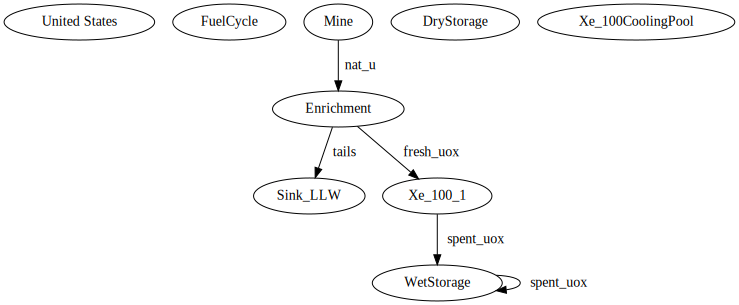

In [33]:
graphs.flow_graph(evaler, label='com')

In [34]:
repository_waste = timeseries.transactions(evaler=evaler, receivers=['WetStorage'])

Text(0, 0.5, 'Mass of waste (kg)')

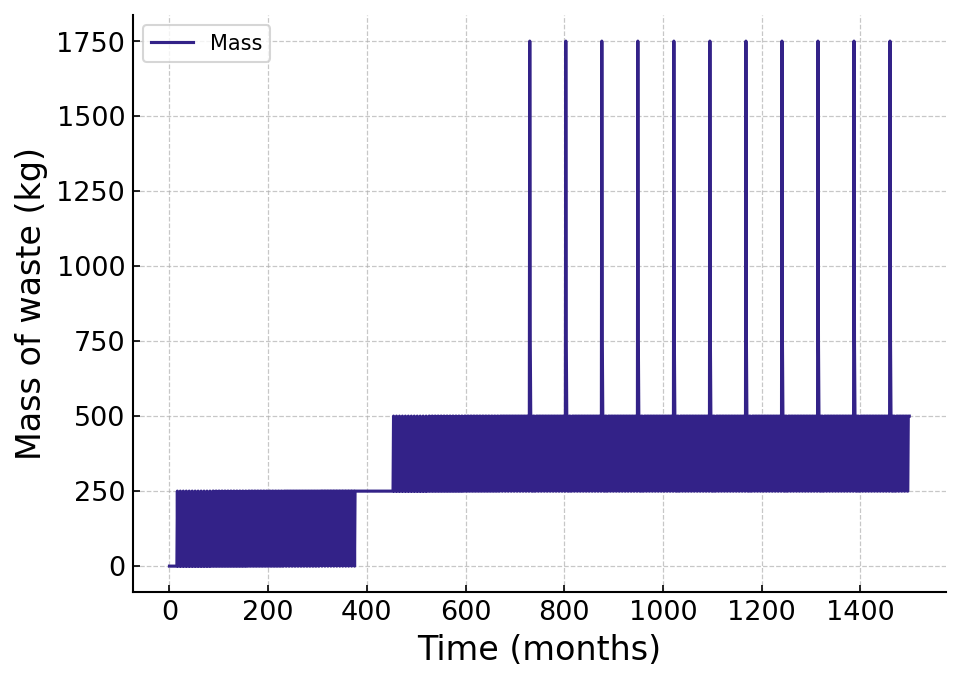

In [35]:
repository_waste.plot(x='Time')
plt.xlabel('Time (months)')
plt.ylabel('Mass of waste (kg)')

Text(0, 0.5, 'Mass of waste (kg)')

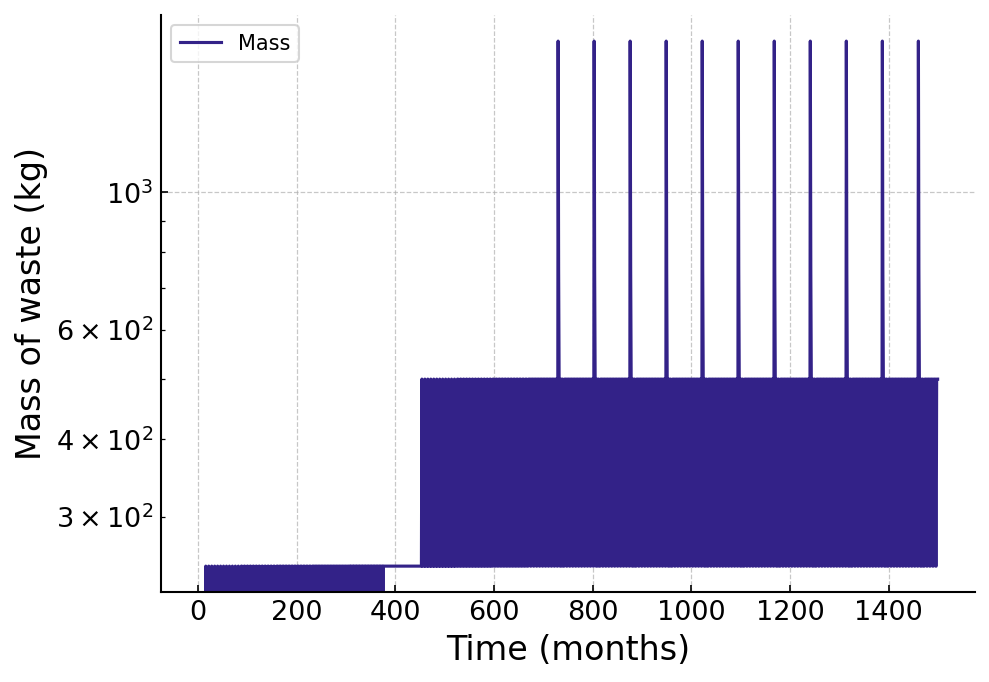

In [36]:
repository_waste.plot(x='Time', logy=True)
plt.xlabel('Time (months)')
plt.ylabel('Mass of waste (kg)')

Text(0, 0.5, 'Mass of waste (kg)')

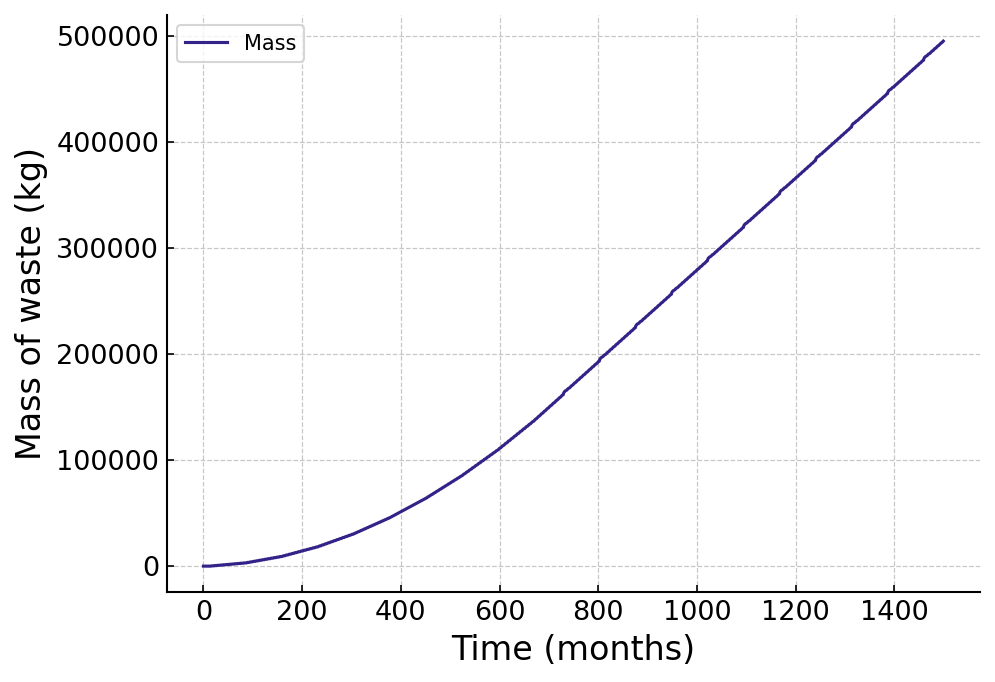

In [37]:
repository_waste['Mass'] = repository_waste['Mass'].cumsum()
repository_waste.plot(x='Time')
plt.xlabel('Time (months)')
plt.ylabel('Mass of waste (kg)')

In [38]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

transactions['spent_uox_total'] = transactions.loc[transactions['Commodity'] == 'spent_uox']['Quantity'].cumsum()
transactions['fresh_uox_total'] = transactions.loc[transactions['Commodity'] == 'fresh_uox']['Quantity'].cumsum()

transactions.ffill(inplace=True)
transactions['total_fuel'] = transactions['spent_uox_total'] + transactions['fresh_uox_total']

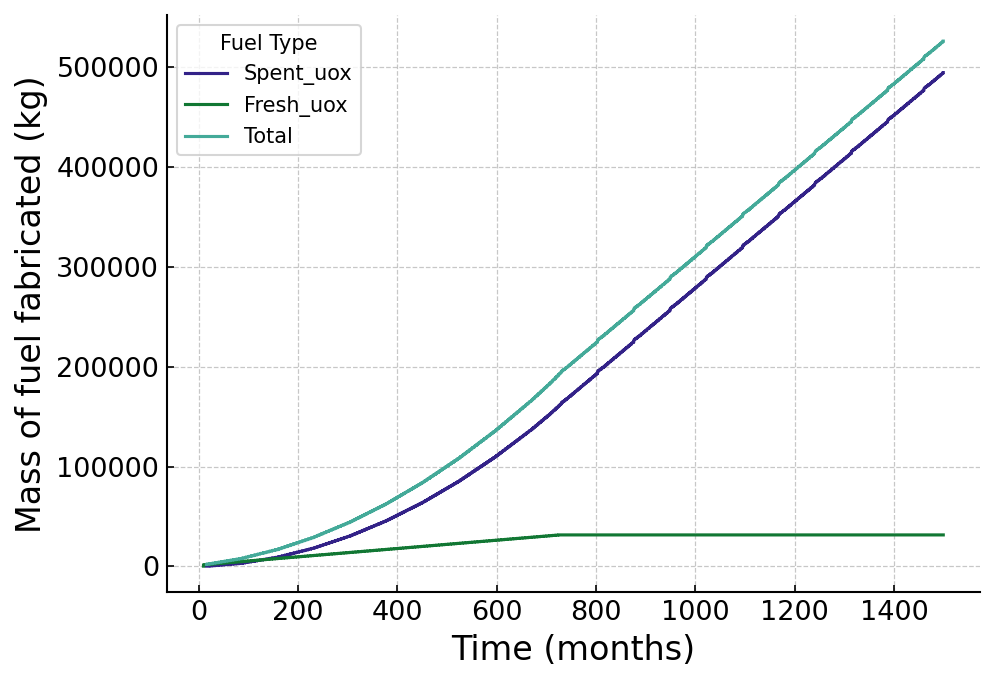

In [39]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'spent_uox_total', 'fresh_uox_total', 'total_fuel']].plot(x = 'Time')
plt.xlabel('Time (months)')
plt.ylabel('Mass of fuel fabricated (kg)')

legend = plt.legend()
legend.get_texts()[0].set_text('Spent_uox')
legend.get_texts()[1].set_text('Fresh_uox')
legend.get_texts()[2].set_text('Total')
legend.set_title('Fuel Type')

In [59]:
transactions['fresh_uox_total'].sort_index()[0:58]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
36         NaN
37         NaN
38         NaN
39         NaN
40         NaN
41         NaN
42         NaN
43         NaN
44         NaN
45         NaN
46         NaN
47         NaN
48         NaN
49         NaN
50     500.248
51    1500.744
52    1500.744
53    1250.620
54    1000.496
55     750.372
56    1750.868
57     500.248
Name: fresh_uox_total, dtype: float64

In [41]:
U235_mass = timeseries.transactions(evaler=evaler, receivers=['Xe_100_1', 'fresh_uox'], nucs=['92235'])
U235_mass['Mass'] = U235_mass['Mass'].cumsum()
U235_mass.plot(x='Time')
plt.xlabel('Time (months)')
plt.ylabel('Mass of U235 (kg)')

ImportError: pyne could not be imported: Unable to format nuclide !

# Sqlite

In [46]:
current_xe = ['Mine', 'Sink_LLW', 'WetStorage',
               'Enrichment', 'DryStorage', 'United States',
               'Xe_100CoolingPool', 'FuelCycle', 'Xe_100_1']

In [47]:
conn = sqlite3.connect('single_xe100_out.sqlite')

In [48]:
cursor = conn.cursor()

In [49]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()

In [77]:
columns

[('FieldTypes',),
 ('InputFiles',),
 ('Info',),
 ('DecayMode',),
 ('InfoExplicitInv',),
 ('TimeStepDur',),
 ('Epsilon',),
 ('XMLPPInfo',),
 ('SolverInfo',),
 ('GreedySolverInfo',),
 ('Compositions',),
 ('Recipes',),
 ('AgentStateAgent',),
 ('AgentState_cycamore_ReactorInfo',),
 ('Prototypes',),
 ('AgentVersions',),
 ('AgentState_cycamore_SinkInfo',),
 ('AgentState_cycamore_SourceInfo',),
 ('AgentPosition',),
 ('AgentState_cycamore_EnrichmentInfo',),
 ('AgentState_cycamore_StorageInfo',),
 ('AgentState_cycamore_DeployInstInfo',),
 ('AgentState_agents_NullRegionInfo',),
 ('AgentEntry',),
 ('BuildSchedule',),
 ('Snapshots',),
 ('NextIds',),
 ('TimeSeriesdemandtails',),
 ('TimeSeriessupplynat_u',),
 ('TimeSeriessupplytails',),
 ('TimeSeriessupplyfresh_uox',),
 ('Resources',),
 ('MaterialInfo',),
 ('ResCreators',),
 ('Transactions',),
 ('TimeSeriesEnrichmentSWU',),
 ('TimeSeriesEnrichmentFeed',),
 ('TimeSeriesdemandnat_u',),
 ('TimeSeriesdemandspent_uox',),
 ('TimeSeriessupplyspent_uox',),


In [66]:
cursor.execute("SELECT * FROM DecomSchedule")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 731, 731)


In [64]:
cursor.execute("SELECT * FROM Prototypes")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'Xe_100_1', 14, ':cycamore:Reactor')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'Sink_HLW', 15, ':cycamore:Sink')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'Sink_LLW', 16, ':cycamore:Sink')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'Mine', 17, ':cycamore:Source')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'Enrichment', 18, ':cycamore:Enrichment')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'WetStorage', 19, ':cycamore:Storage')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'DryStorage', 20, ':cycamore:Storage')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'Xe_100CoolingPool', 21, ':cycamore:Storage')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'FuelCycle', 22, ':cycamore:DeployInst')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 'United States', 23, ':agents:NullRegion')


In [63]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 25, 'Xe_100_1', 0, 10)


In [67]:
cursor.execute("SELECT * FROM ReactorEvents")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 10, 'LOAD', '7 assemblies')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 10, 'CYCLE_START', '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 16, 'TRANSMUTE', '1 assemblies')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 16, 'CYCLE_END', '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 16, 'DISCHARGE', '1 assemblies')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 16, 'LOAD', '1 assemblies')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 16, 'CYCLE_START', '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 22, 'TRANSMUTE', '1 assemblies')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 22, 'CYCLE_END', '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 22, 'DISCHARGE', '1 assemblies')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 22, 'LOAD', '1 assemblies')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 22, 'CYCLE_START', '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 28, 'TRANSMUTE', '1 assemblies')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 28, 'CYCLE_END', '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 28, 

In [68]:
cursor.execute("SELECT * FROM TimeSeriesPower")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 10, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 11, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 12, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 13, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 14, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 15, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 16, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 17, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 18, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 19, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 20, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 21, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 22, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 23, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 24, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 25, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 26, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 27, 80.0, '')
(b'GN\xe6D

In [69]:
cursor.execute("SELECT * FROM TimeSeriessupplyPOWER")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 10, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 11, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 12, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 13, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 14, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 15, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 16, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 17, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 18, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 19, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 20, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 21, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 22, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 23, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 24, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 25, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 26, 80.0, '')
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 40, 27, 80.0, '')
(b'GN\xe6D

In [70]:
cursor.execute("SELECT * FROM AgentStateInventories")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56692)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56688)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56690)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56698)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56700)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56702)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56770)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56772)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56774)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56776)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56778)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56843)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56845)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56847)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 32, 1500, 'inventory', 56

In [71]:
cursor.execute("SELECT * FROM FieldTypes")
rows = cursor.fetchall()

for row in rows:
    print(row)

('InputFiles', 'SimId', 7)
('InputFiles', 'Data', 6)
('Info', 'SimId', 7)
('Info', 'Handle', 4)
('Info', 'InitialYear', 1)
('Info', 'InitialMonth', 1)
('Info', 'Duration', 1)
('Info', 'Seed', 1)
('Info', 'Stride', 1)
('Info', 'ParentSimId', 7)
('Info', 'ParentType', 4)
('Info', 'BranchTime', 1)
('Info', 'CyclusVersion', 4)
('Info', 'CyclusVersionDescribe', 4)
('Info', 'SqliteVersion', 4)
('Info', 'Hdf5Version', 4)
('Info', 'BoostVersion', 4)
('Info', 'LibXML2Version', 4)
('Info', 'CoinCBCVersion', 4)
('DecayMode', 'SimId', 7)
('DecayMode', 'Decay', 4)
('InfoExplicitInv', 'SimId', 7)
('InfoExplicitInv', 'RecordInventory', 0)
('InfoExplicitInv', 'RecordInventoryCompact', 0)
('TimeStepDur', 'SimId', 7)
('TimeStepDur', 'DurationSecs', 1)
('Epsilon', 'SimId', 7)
('Epsilon', 'GenericEpsilon', 3)
('Epsilon', 'ResourceEpsilon', 3)
('XMLPPInfo', 'SimId', 7)
('XMLPPInfo', 'LibXMLPlusPlusVersion', 4)
('SolverInfo', 'SimId', 7)
('SolverInfo', 'Solver', 4)
('SolverInfo', 'ExclusiveOrders', 0)
('Gre

In [72]:
cursor.execute("SELECT * FROM Info")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', '', 1965, 1, 1500, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [73]:
cursor.execute("SELECT * FROM NextIds")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 0, 'Agent', 40)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 0, 'Transaction', 0)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 0, 'Composition', 7)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 0, 'ResourceState', 1)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 0, 'ResourceObj', 1)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 0, 'Product', 1)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 1500, 'Agent', 41)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 1500, 'Transaction', 9109)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 1500, 'Composition', 2391)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 1500, 'ResourceState', 113334)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 1500, 'ResourceObj', 100200)
(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 1500, 'Product', 1)


In [78]:
cursor.execute("SELECT * FROM InfoExplicitInv")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'GN\xe6D fOy\xb4~\x9d\xc3r5z\xbe', 0, 0)
